# DECODING FINANCIAL TRENDS: AN ANALYSIS OF WORLD BANK FINANCIAL INDICATORS

# DESCRIPTION & PURPOSES

How financial markets and businesses developed over time can tell much about the direction a country is going toward. For example they can explain which countries are more prone to massive layoffs in the future; or those that will experience the higher amount of new players (i.e businesses) entering the market.  
Considered altogether, these different indicators provide a clear framework of the market trends for each single country. In turn, this helps in forecasting the momentum of each country along with its major market trends.

The world bank is one of the biggest resource when it comes to any-kind of indicator. The following link gives access to all of those, along with the relative explanation:
https://datatopics.worldbank.org/world-development-indicators/themes/states-and-markets.html

In this specific case, data will be accessed through API (check this link for documentation: https://datahelpdesk.worldbank.org/knowledgebase/articles/889392-api-documentation). Moreover, the focus is going to be only on market-related indicators in a 10-year period (2012 to 2022), as the aim is to have a general overview of the financial situation in different States.

More in details, the Countries take into consideration are:

- Canada
- China
- France
- Italy
- Qatar
- South Africa
- United States

While the indicators chosen for the analysis are:

- CM.MKT.LCAP.GD.ZS: Market_Capitalization
- CM.MKT.TRAD.GD.ZS: Market_Liquidity
- CM.MKT.TRNR: Turnover_Ratio
- CM.MKT.LDOM.NO: Listed_Companies
- CM.MKT.INDX.ZG: SP500_GlobIndex


Prior to begin the analysis, let's load the packages needed.

In [95]:
#import packages for data cleaning, collecting and analysis
import pandas as pd
import numpy as np
import requests
import wbdata
import os

#ARIMA, HW & accuracy measures
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#packages for plotting
from IPython.display import display
import seaborn as sns
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import plotly.io as pio

In [96]:
#function to save static plots
# Create the img directory if it doesn't exist
if not os.path.exists('img'):
    os.makedirs('img')

def save_plotly_figures(fig, filename):
    """
    Saves a Plotly figure to the img folder.
    
    Parameters:
    - fig: The Plotly figure to save.
    - filename: The name of the file to save as (without extension).
    """
    file_path = os.path.join('img', f"{filename}.html")
    pio.write_html(fig, file_path)  # Save as HTML file
    print(f"Figure saved as: {file_path}")
    
#function to save interactive plots
def save_plotly_figure(fig, filename, format='html'):
    """
    Save a Plotly figure as an HTML file or an image.

    Parameters:
    fig : plotly.graph_objs.Figure
        The Plotly figure to save.
    filename : str
        The name of the file to save (without extension).
    format : str, optional
        The format to save the figure ('html' or 'png', 'jpeg', 'webp', 'svg', 'pdf').
        Default is 'html'.
    """
    if format == 'html':
        pio.write_html(fig, file=filename + '.html', auto_open=False)
        print(f"Figure saved as {filename}.html")
    elif format in ['png', 'jpeg', 'webp', 'svg', 'pdf']:
        pio.write_image(fig, filename + '.' + format)
        print(f"Figure saved as {filename}.{format}")
    else:
        raise ValueError("Invalid format. Choose 'html' or one of 'png', 'jpeg', 'webp', 'svg', 'pdf'.")


## DATA COLLECTION & CLEANING & MANIPULATION

The first thing to do is to retrieve and load data from the WB website. 
To make thing easier, we will define  countries, map the indicators by giving them an understandable name and set the time range (2012 - 2022). After that, it is possible to build a dataframe containing all the indicators for each countries by accessing the WV API. This df will then be unstacked, to let it be more readable.

In [97]:
#listing the Country API codes
countries = ["US",
               "CA", #canada
               "IT", #italia
               "FR", #france
               "CN", #china
               "QA", #qatar
               "ZA" #South Africa
               ]
 
#set up the indicators needed
#giving them a clear defintion
indicators = {"CM.MKT.LCAP.GD.ZS": "Market_Capitalization",
              "CM.MKT.TRAD.GD.ZS": "Market_Liquidity",
              "CM.MKT.TRNR": "Turnover_Ratio",
              "CM.MKT.LDOM.NO": "Listed_Companies",
              "CM.MKT.INDX.ZG": "SP500_GlobIndex"
              } 
#create a tuples for the dates we are interested into 
dates = ("2012-01-01", "2022-01-01")

#grab indicators above for countires above and load into data frame
df = wbdata.get_dataframe(indicators, country=countries, parse_dates=True, date = dates)

#df is "pivoted", pandas' unstack fucntion helps reshape it into something plottable
dfu = df.unstack(level=0)
#show the df
dfu

Market_Capitalization                                    \
country                   Canada      China      France      Italy   
date                                                                 
2012-01-01            112.667433  43.334455   67.377418  23.087545   
2013-01-01            114.471175  41.263836   81.834493  28.734086   
2014-01-01            116.041579  57.323049   73.036475  27.165117   
2015-01-01            102.370079  74.022199   85.615244        NaN   
2016-01-01            130.466597  65.169892   87.306014        NaN   
2017-01-01            143.522053  70.762953  105.940446        NaN   
2018-01-01            112.320751  45.519408   84.772010        NaN   
2019-01-01            138.158155  60.010722         NaN        NaN   
2020-01-01            159.538505  83.585104         NaN        NaN   
2021-01-01            162.599382  81.016127         NaN        NaN   
2022-01-01            126.983151  64.139833         NaN        NaN   

                                                  Market_Liquidity  \
country          Qatar South Africa United States           Canada   
date                                                                 
2012-01-01         NaN   208.959959    114.853991        73.725514   
2013-01-01   76.776551   235.182091    142.380812        71.676772   
2014-01-01   90.125175   244.998287    149.536477        74.417219   
2015-01-01   88.139297   212.265471    137.018385        70.418794   
2016-01-01  102.037608   293.993489    145.452418        75.482372   
2017-01-01   81.074346   322.710975    163.780010        77.619357   
2018-01-01   88.934165   213.523690    147.344853        79.616973   
2019-01-01   90.746482   271.322876    158.380660        82.155437   
2020-01-01  114.529616   310.835168    194.953615       118.021314   
2021-01-01  103.043192   272.067355    205.766188       109.089676   
2022-01-01   70.736830   289.127168    156.532828       104.060418   

                                   ... Listed_Companies               \
country          China     France  ...            Qatar South Africa   
date                               ...                                 
2012-01-01   58.920416  40.037578  ...             42.0        338.0   
2013-01-01   80.413816  39.315980  ...             42.0        322.0   
2014-01-01  114.163396  40.918507  ...             43.0        322.0   
2015-01-01  355.519219  54.459261  ...             43.0        316.0   
2016-01-01  162.864309        NaN  ...             44.0        303.0   
2017-01-01  139.907739        NaN  ...             45.0        294.0   
2018-01-01   94.067858        NaN  ...             46.0        289.0   
2019-01-01  127.797373        NaN  ...             47.0        274.0   
2020-01-01  215.033283        NaN  ...              NaN        264.0   
2021-01-01  226.481217        NaN  ...              NaN        252.0   
2022-01-01  181.540050        NaN  ...              NaN        237.0   

                         SP500_GlobIndex                                   \
country    United States          Canada      China     France      Italy   
date                                                                        
2012-01-01        4102.0        5.993818  17.171175  15.230660  11.028045   
2013-01-01        4180.0        2.979761   7.264348  17.985920  23.058107   
2014-01-01        4369.0       -2.136173   3.026383  -0.540044 -12.020270   
2015-01-01        4381.0      -26.166835  -6.007182   8.526359   3.199872   
2016-01-01        4331.0       22.562033  -2.024998   4.857604 -13.003390   
2017-01-01        4336.0       13.746720  46.030025   9.260002  29.770295   
2018-01-01        4013.0      -19.376128 -20.515480 -10.952725 -20.948881   
2019-01-01        3910.0       25.322617  19.261354  26.367614  24.537382   
2020-01-01        4104.0        4.483173  27.872233  -7.136931   2.683523   
2021-01-01        4774.0       22.682613 -20.647621  28.850681  14.871914   
2022-01-01        4642.0      -14.79837

Since there may be the necessity to analyze just a single indicator, let's build a dataframe for each one of them.

In [98]:
#filter to divide each column and re-shape the df to have 1 single df for each indicator
#market capitalization
mrkCap = pd.DataFrame(
    dfu["Market_Capitalization"]
)
#market Liquidity
mrkLiq = pd.DataFrame(
    dfu["Market_Liquidity"]
)
#market Liquidity
TurnRatio = pd.DataFrame(
    dfu["Turnover_Ratio"]
)
#listed Company
ListComp = pd.DataFrame(
    dfu["Listed_Companies"]
)
#listed Company
SP500Index = pd.DataFrame(
    dfu["SP500_GlobIndex"]
)

Having cleaned data is fundamental to get sound results. Since the study comprehend several dfs, let's set up a function to clean the data. This function, named clean(df, df_name), will (consequently):

- check the date is the index
- check data type
- count the null values (NaN)
- replace the null-values with 0 (to avoid issues while modeling)
- round the decimal to 2
- save the cleaned dataframe with the name provided in "df_name" in the out_folder

In [99]:
#build a function that check data types, counts the null value, replace those with 0 and save the new df in .csv
def clean(df, df_name) :
    #check the index (should be the date)
    print("The Index should be the date:")
    print(df.index)
    #check the data type
    print("Variables are of type:")
    print(df.dtypes)
    #count the nulls values
    print("Null values for each column:")
    print(df.isnull().sum())
    #replace the null with 0
    df = df.fillna(value = 0)
    #round the decimals to 2
    df = df.round(2)
    #save the updated df as csv with the name provided in "df_name"
    df.to_csv(f"out_data/{df_name}.csv", index = True)
    return df

Let's clean all the df for each indicators. Remember that those cleaned df are saved in the out_data folder.

In [100]:
clean(mrkCap, "mrkCap")
clean(mrkLiq, "mrkLiq")
clean(TurnRatio, "TurnRatio")
clean(ListComp, "ListComp")
clean(SP500Index, "SP500Index")

The Index should be the date:
DatetimeIndex(['2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
               '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01',
               '2020-01-01', '2021-01-01', '2022-01-01'],
              dtype='datetime64[ns]', name='date', freq=None)
Variables are of type:
country
Canada           float64
China            float64
France           float64
Italy            float64
Qatar            float64
South Africa     float64
United States    float64
dtype: object
Null values for each column:
country
Canada           0
China            0
France           4
Italy            8
Qatar            1
South Africa     0
United States    0
dtype: int64
The Index should be the date:
DatetimeIndex(['2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
               '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01',
               '2020-01-01', '2021-01-01', '2022-01-01'],
              dtype='datetime64[ns]', name='date', freq=None)
Variables are

country,Canada,China,France,Italy,Qatar,South Africa,United States
date,,,,,,,
2012-01-01,5.99,17.17,15.23,11.03,-1.86,15.75,13.41
2013-01-01,2.98,7.26,17.99,23.06,23.97,-7.45,29.60
2014-01-01,-2.14,3.03,-0.54,-12.02,23.00,3.86,11.39
2015-01-01,-26.17,-6.01,8.53,3.20,-18.65,-26.62,-0.73
2016-01-01,22.56,-2.02,4.86,-13.00,2.19,17.62,9.54
2017-01-01,13.75,46.03,9.26,29.77,-16.77,30.62,19.42
2018-01-01,-19.38,-20.52,-10.95,-20.95,22.22,-25.89,-6.24
2019-01-01,25.32,19.26,26.37,24.54,-1.90,8.55,28.88
2020-01-01,4.48,27.87,-7.14,2.68,-4.04,-7.02,16.26


The cleaned dfs are the ones that we are going to analyze. Let's load them all.

In [101]:
mrkCapclean = pd.read_csv("out_data/mrkcap.csv")
mrkLiqclean = pd.read_csv("out_data/mrkLiq.csv")
TurnRatioclean = pd.read_csv("out_data/TurnRatio.csv")
ListCompclean = pd.read_csv("out_data/ListComp.csv")
SP500Indexclean = pd.read_csv("out_data/SP500Index.csv")

All these dfs should now be ready to be analyzed. Let's double check that they have been properly loaded by printin the mrkCapclean df.

In [102]:
print("Double check that data are loaded:")
print(mrkCapclean)

Double check that data are loaded:
          date  Canada  China  France  Italy   Qatar  South Africa  \
0   2012-01-01  112.67  43.33   67.38  23.09    0.00        208.96   
1   2013-01-01  114.47  41.26   81.83  28.73   76.78        235.18   
2   2014-01-01  116.04  57.32   73.04  27.17   90.13        245.00   
3   2015-01-01  102.37  74.02   85.62   0.00   88.14        212.27   
4   2016-01-01  130.47  65.17   87.31   0.00  102.04        293.99   
5   2017-01-01  143.52  70.76  105.94   0.00   81.07        322.71   
6   2018-01-01  112.32  45.52   84.77   0.00   88.93        213.52   
7   2019-01-01  138.16  60.01    0.00   0.00   90.75        271.32   
8   2020-01-01  159.54  83.59    0.00   0.00  114.53        310.84   
9   2021-01-01  162.60  81.02    0.00   0.00  103.04        272.07   
10  2022-01-01  126.98  64.14    0.00   0.00   70.74        289.13   

    United States  
0          114.85  
1          142.38  
2          149.54  
3          137.02  
4          145.45  
5   

As noticeable, the df are stored in a wide format. It may be come in handy to have them also in a long format. The function widetolong(df, varname) does exactly this by: 

- resetting the index 
- melting the dataframe to adjust the column into the new format
- renaming the columns

In [103]:
def widetolong(df, varname):
    df = df.reset_index() #reset the index
    df = df.melt(id_vars = "date" , #this column is the index
               value_vars = ["Canada", "China", "France", "Italy", "Qatar", "South Africa", "United States"]) #this column is for the value col
    df = df.rename(columns = {"value" : f"{varname}" , "variable" : "state"}) #rename the col with proper names
    return(df)

By applying this function to all dfs, all dfs will become long-dfs.

In [104]:
mrkCaplong = widetolong(mrkCapclean, "mrk_cap")
mrkLiqlong = widetolong(mrkLiqclean, "mrk_liq")
TurnRatiolong = widetolong(TurnRatioclean, "turnover_ratio")
ListComplong = widetolong(ListCompclean, "listed_comp")
SP500Indexlong = widetolong(SP500Indexclean, "SP500_index")

To be sure that the transformation has been performed properly, let's print one df as a try.

In [105]:
print("Checking the long df has been saved properly:")
print(mrkCaplong)

Checking the long df has been saved properly:
          date          state  mrk_cap
0   2012-01-01         Canada   112.67
1   2013-01-01         Canada   114.47
2   2014-01-01         Canada   116.04
3   2015-01-01         Canada   102.37
4   2016-01-01         Canada   130.47
..         ...            ...      ...
72  2018-01-01  United States   147.34
73  2019-01-01  United States   158.38
74  2020-01-01  United States   194.95
75  2021-01-01  United States   205.77
76  2022-01-01  United States   156.53

[77 rows x 3 columns]


Finally, let's merge all the long dfs to get a single dataframe where each column corresponds to a single indicator.

In [106]:
#create a list with allo the long dfs 
df_list = [mrkCaplong, mrkLiqlong, TurnRatiolong, ListComplong, SP500Indexlong]

#perform the merge
final_df = df_list[0] #start with the first df
for df in df_list[1:]:
    final_df = pd.merge(final_df, df, on = ["date", "state"], how = "inner")

#display the result
final_df

,date,state,mrk_cap,mrk_liq,turnover_ratio,listed_comp,SP500_index
0,2012-01-01,Canada,112.67,73.73,65.44,3874.0,5.99
1,2013-01-01,Canada,114.47,71.68,62.62,3810.0,2.98
2,2014-01-01,Canada,116.04,74.42,64.15,3691.0,-2.14
3,2015-01-01,Canada,102.37,70.42,68.80,3501.0,-26.17
4,2016-01-01,Canada,130.47,75.48,57.55,3368.0,22.56
...,...,...,...,...,...,...,...
72,2018-01-01,United States,147.34,237.52,0.00,4013.0,-6.24
73,2019-01-01,United States,158.38,168.87,0.00,3910.0,28.88
74,2020-01-01,United States,194.95,192.69,0.00,4104.0,16.26
75,2021-01-01,United States,205.77,194.43,0.00,4774.0,26.89


Another cleaning phase's fundamental part is checking that each column has the same amount of observation. Let's do that.

In [107]:
final_df.count()

date              77
state             77
mrk_cap           77
mrk_liq           77
turnover_ratio    77
listed_comp       77
SP500_index       77
dtype: int64

That's a good news: the amount of obs is the same for every column. Now let's count how many missing values there are for each single indicator.  
Remember that, after the cleaning phase above, missing data are represented by 0s. As such, we need a function that counts the 0s in each column. Let's build that.

In [108]:
def count_zeros(df, column_name):
    # Group by 'state' and count how many times 0 appears in the specified column
    return df.groupby('state')[column_name].apply(lambda x: (x == 0).sum())


Finally, check missing data for all indicators. Results may give interesting insights.

In [109]:
#count the 0s in each column of the final df
print(count_zeros(final_df, "mrk_cap"))
print(count_zeros(final_df, "mrk_liq"))
print(count_zeros(final_df, "turnover_ratio"))
print(count_zeros(final_df, "listed_comp"))
print(count_zeros(final_df, "SP500_index"))

state
Canada           0
China            0
France           4
Italy            8
Qatar            1
South Africa     0
United States    0
Name: mrk_cap, dtype: int64
state
Canada           0
China            0
France           7
Italy            8
Qatar            0
South Africa     0
United States    0
Name: mrk_liq, dtype: int64
state
Canada           0
China            0
France           7
Italy            8
Qatar            1
South Africa     0
United States    5
Name: turnover_ratio, dtype: int64
state
Canada           0
China            0
France           4
Italy            8
Qatar            3
South Africa     0
United States    0
Name: listed_comp, dtype: int64
state
Canada           0
China            0
France           0
Italy            0
Qatar            0
South Africa     0
United States    0
Name: SP500_index, dtype: int64


As evident, France and Italy are the countries with the greatest amount of 0s (i.e NaN). The natural question now is: why so?  
Let's try to zoom-in by focusing just on these two countries to see if we can spot some shared patterns. Keep in mind that both of them are European Countires (and EU members too).

In [110]:
#Italy
italy = final_df[final_df["state"] == "Italy"]
italy

,date,state,mrk_cap,mrk_liq,turnover_ratio,listed_comp,SP500_index
33,2012-01-01,Italy,23.09,37.50,162.42,303.0,11.03
34,2013-01-01,Italy,28.73,35.95,125.11,285.0,23.06
35,2014-01-01,Italy,27.17,95.08,350.01,290.0,-12.02
36,2015-01-01,Italy,0.00,0.00,0.00,0.0,3.20
37,2016-01-01,Italy,0.00,0.00,0.00,0.0,-13.00
38,2017-01-01,Italy,0.00,0.00,0.00,0.0,29.77
39,2018-01-01,Italy,0.00,0.00,0.00,0.0,-20.95
40,2019-01-01,Italy,0.00,0.00,0.00,0.0,24.54
41,2020-01-01,Italy,0.00,0.00,0.00,0.0,2.68
42,2021-01-01,Italy,0.00,0.00,0.00,0.0,14.87


In [111]:
#france
france = final_df[final_df["state"] == "France"]
france

,date,state,mrk_cap,mrk_liq,turnover_ratio,listed_comp,SP500_index
22,2012-01-01,France,67.38,40.04,59.42,562.0,15.23
23,2013-01-01,France,81.83,39.32,48.04,500.0,17.99
24,2014-01-01,France,73.04,40.92,56.02,495.0,-0.54
25,2015-01-01,France,85.62,54.46,63.61,490.0,8.53
26,2016-01-01,France,87.31,0.00,0.00,485.0,4.86
27,2017-01-01,France,105.94,0.00,0.00,465.0,9.26
28,2018-01-01,France,84.77,0.00,0.00,457.0,-10.95
29,2019-01-01,France,0.00,0.00,0.00,0.0,26.37
30,2020-01-01,France,0.00,0.00,0.00,0.0,-7.14
31,2021-01-01,France,0.00,0.00,0.00,0.0,28.85


Speaking about Italy, the pattern is clear: from 2015 there are no more available data for each indicator except the SP500_Index.  
Turning to France, instead, there is not a single year when data become not available. What it is interesting is that listed companies and market capitalzion stop to be available in the same year. The same is for market liquidity and the turnover ration. Still, the only indicator that has no missing data is the SP500_index.  

When there are so many missing data, the first thing to do is to check that the API loaded the information correctly.
After manually browsing the WB official website, we discovered that this data is still not available there. That is our main interest: be sure that no mistakes were done during the import. 

To make thing easier, we are not going to consider these two Countries in our analysis.
Since available data are a few, they will not add many information to our study.  
On the other hand, it would be interesting to delve more in profundity on the reasons why these countries stopped discolsing data on those specific years. Could it be due to a new EU regulation? An Internal law? A change in the goverment? We will leave these question for law and politics  experts.

Seeing that, let's exclude both Italy and France from our df. As such, the df is narrowed down to: Canada, China, Qatar, South Africa, United States.

In [112]:
#drop Italy and France from the df
#drop all the rows containing Italy
noIt = final_df.drop(final_df[final_df['state'] == 'Italy'].index)
#drop all the rows containing France
mrkdf = noIt.drop(noIt[noIt['state'] == 'France'].index)
#resetting the index to avoid miscounting
mrkdf = mrkdf.reset_index()
#drop the column index
mrkdf = mrkdf.drop(columns = "index")
#print the df to check it
mrkdf

,date,state,mrk_cap,mrk_liq,turnover_ratio,listed_comp,SP500_index
0,2012-01-01,Canada,112.67,73.73,65.44,3874.0,5.99
1,2013-01-01,Canada,114.47,71.68,62.62,3810.0,2.98
2,2014-01-01,Canada,116.04,74.42,64.15,3691.0,-2.14
3,2015-01-01,Canada,102.37,70.42,68.80,3501.0,-26.17
4,2016-01-01,Canada,130.47,75.48,57.55,3368.0,22.56
5,2017-01-01,Canada,143.52,77.62,54.08,3278.0,13.75
6,2018-01-01,Canada,112.32,79.62,70.88,3330.0,-19.38
7,2019-01-01,Canada,138.16,82.16,59.46,3358.0,25.32
8,2020-01-01,Canada,159.54,118.02,73.98,3922.0,4.48
9,2021-01-01,Canada,162.60,109.09,67.09,3455.0,22.68


We drop the SP500_index column too. That's to make the df "slimmer" and fitter to our purposes. We will consider SP500_Index later on to perform a more detailed analysis for all the Countries (i.e taking into consideration France and Italy). That's to make the df "slimmer".

In [113]:
mrkdf = mrkdf.drop(columns = "SP500_index")
mrkdf

,date,state,mrk_cap,mrk_liq,turnover_ratio,listed_comp
0,2012-01-01,Canada,112.67,73.73,65.44,3874.0
1,2013-01-01,Canada,114.47,71.68,62.62,3810.0
2,2014-01-01,Canada,116.04,74.42,64.15,3691.0
3,2015-01-01,Canada,102.37,70.42,68.80,3501.0
4,2016-01-01,Canada,130.47,75.48,57.55,3368.0
5,2017-01-01,Canada,143.52,77.62,54.08,3278.0
6,2018-01-01,Canada,112.32,79.62,70.88,3330.0
7,2019-01-01,Canada,138.16,82.16,59.46,3358.0
8,2020-01-01,Canada,159.54,118.02,73.98,3922.0
9,2021-01-01,Canada,162.60,109.09,67.09,3455.0


# ANALYSIS

Usually, the first step in the analysis phase is to compute some summary statistics (mean, std, min, max and so on) for all the variables.
Let's do that.

In [114]:
round(mrkdf.describe(), 2)

,mrk_cap,mrk_liq,turnover_ratio,listed_comp
count,55.00,55.00,55.00,55.00
mean,138.23,107.47,86.56,2883.04
std,75.42,77.86,97.36,3131.37
min,0.00,7.56,0.00,0.00
25%,82.33,58.42,20.78,269.00
50%,116.04,80.41,54.08,3278.00
75%,163.19,170.50,137.15,3967.50
max,322.71,355.52,480.29,12730.00


Note: The row labeled "50%" represents the median of the series. By comparing it with the mean, we can get a rough understanding of whether the series contains outliers. For instance, the "listed_comp" series may contain outliers. However, since the aim here is not forecasting but data description, we will retain these outliers as they provide valuable information. Therefore, we will not apply any smoothing techniques to address them.

Next, we will build the correlation matrix for the indicators. This will help us understand how each variable moves in relation to the others.

In [115]:
# create a copy so that the original DF is not affected
# drop the columns year and country
mrkdf_corr = mrkdf.drop(['date', 'state'], axis='columns')
mrkdf_corr.describe()
mrkdf_corr.corr()

,mrk_cap,mrk_liq,turnover_ratio,listed_comp
mrk_cap,1.000000,0.023733,-0.425372,-0.312310
mrk_liq,0.023733,1.000000,0.631290,0.614742
turnover_ratio,-0.425372,0.631290,1.000000,0.596694
listed_comp,-0.312310,0.614742,0.596694,1.000000


Let's plot that.

<Axes: >

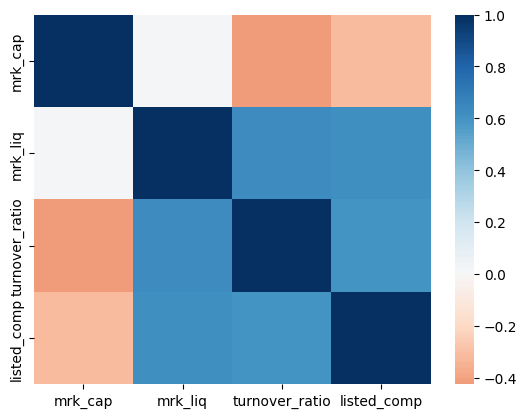

In [116]:
#plot the correlation matrix
sns.heatmap(mrkdf_corr.corr(), cmap='RdBu', center=0)

The correlogram gives few insights about the variables:

- Market Capitalization seems to be negatively correlated with other variables, especially turnover ratio and the number of listed companies, implying that larger markets in terms of value might have lower trading activity (turnover) and fewer listed companies.
- Market Liquidity is positively correlated with both turnover ratio and listed companies, suggesting that markets with more listed companies are more liquid, and liquidity is associated with higher trading frequency.
- Turnover Ratio is closely tied to market liquidity and the number of listed companies, meaning that markets with more trading activity tend to be more liquid and have more companies listed

Generally, markets with high liquidity and more listed companies tend to have higher turnover ratios, but market capitalization doesn't seem to have a strong positive relationship with these factors. Instead, larger market capitalizations are somewhat inversely related to trading activity and the number of listed companies.

## LISTED COMPANIES

Considering each single indicators one-by-one helps in performing a more detailed analysis. To begin, we consider the listed companies to get an overview of how much companies have been formed or have been gone public for the past years.
In details, will compare the number of listed company in 2012 with the ones in 2022 (last avaialble year).
The code below performs this task.

In [117]:
#keep just the year 2012 and 2022
listcomp = mrkdf.loc[(mrkdf["date"] == "2012-01-01") | (mrkdf["date"] == "2022-01-01")]
#keep just the column date, state and listed_comp
listcomp = listcomp.loc[:, ['date', "state", "listed_comp"]]
# Assuming your DataFrame is called listcomp
listcomp_pivot = listcomp.pivot(index='state', columns='date', values='listed_comp')

# Reset the column index so that "date" is removed
listcomp_pivot.columns = listcomp_pivot.columns.get_level_values(0)

# Alternatively, you can also convert the dates to string if they are not already
listcomp_pivot.columns = listcomp_pivot.columns.astype(str)

# Display the cleaned pivoted DataFrame
listcomp_pivot

date,2012-01-01,2022-01-01
state,,
Canada,3874.0,3534.0
China,2494.0,11497.0
Qatar,42.0,0.0
South Africa,338.0,237.0
United States,4102.0,4642.0


Although numbers are meaningful, plots provide a quicker way to interpret the data.

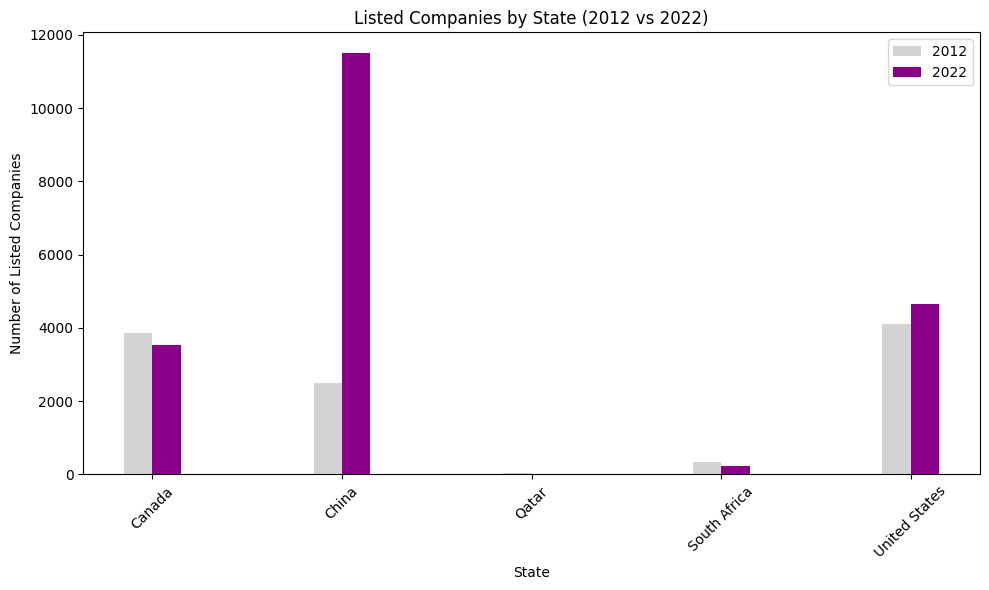

In [118]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Set the positions for the bars on the x-axis
states = listcomp_pivot.index
years = listcomp_pivot.columns
x = np.arange(len(states))  # The label locations
width = 0.15  # The width of the bars

# Create bar plots for both years
plt.bar(x - width/2, listcomp_pivot['2012-01-01'], width, label='2012', color='lightgrey')
plt.bar(x + width/2, listcomp_pivot['2022-01-01'], width, label='2022', color='darkmagenta')

# Add labels, title, and custom x-axis tick labels
plt.xlabel('State')
plt.ylabel('Number of Listed Companies')
plt.title('Listed Companies by State (2012 vs 2022)')
plt.xticks(x, states, rotation=45)  # Rotate state labels for better readability

# Add a legend
plt.legend()

# Save the figure to the img directory
plt.savefig('img/ListCompanies.png', bbox_inches='tight')

# Display the plot
plt.tight_layout()
plt.show()

Not surprisingly, China has both the greatest number of public companies and has witnessed the largest growth in this number. This may be due to the large size of its territory or new policies that have encouraged companies to go public or attracted foreign investments.

Following China are the United States. Interestingly, in 2012, the U.S. had more listed companies than China, but the tremendous growth China has experienced since then has surpassed U.S. numbers.

In contrast, Canada and South Africa have seen a decline in the number of publicly listed companies.

A special note on Qatar: the number of listed companies in 2022 is a missing value, but it's almost certain that Qatar’s number could not compete with the other countries.

## MARKET CAPITALIZATION & MARKET LIQUIDITY

### Market Capitalization

According to the World Bank, market capitalization (also known as market value) is the share price multiplied by the number of outstanding shares (including all share classes) for listed domestic companies. In a nutshell, market capitalization gives an indication of the size of a country's public market.

Now, let's plot these values for each country.

In [119]:
#add a column displaying just year
mrkCapclean["year"] = pd.to_datetime(mrkCapclean["date"])
mrkCapclean["year"] = mrkCapclean["year"].dt.year


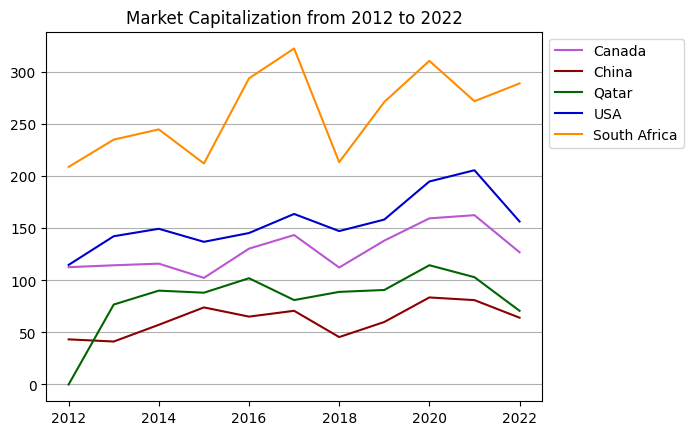

In [120]:
#define the plot
fid, ax = plt.subplots()
#focus on the mrk Cap (mrkCapclean df) and plot to check the changes in market capitalization
plt.plot(mrkCapclean["year"], mrkCapclean["Canada"], label = "Canada", color = "mediumorchid" )
plt.plot(mrkCapclean["year"] , mrkCapclean["China"], label = "China", color = "darkred")
plt.plot(mrkCapclean["year"] , mrkCapclean["Qatar"], label = "Qatar", color = "darkgreen")
plt.plot(mrkCapclean["year"] , mrkCapclean["United States"], label = "USA", color = "mediumblue")
plt.plot(mrkCapclean["year"] , mrkCapclean["South Africa"], label = "South Africa", color = "darkorange" )

#add horizontal grids
ax.grid(axis = "y")

#add the legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
#add the title
plt.title("Market Capitalization from 2012 to 2022")

# Save the figure to the img directory
plt.savefig('img/MarketCap.png', bbox_inches='tight')

#show the chart
plt.show()

Let's make the chart fancier by making it interactive.

In [121]:
import plotly.graph_objects as go

# Create traces for each country
fig = go.Figure()

fig.add_trace(go.Scatter(x=mrkCapclean["year"], y=mrkCapclean["Canada"],
                         mode='lines+markers', name='Canada',
                         line = dict(color = "mediumorchid")))
fig.add_trace(go.Scatter(x=mrkCapclean["year"], y=mrkCapclean["China"],
                         mode='lines+markers', name='China',
                         line = dict(color = "darkred")))
fig.add_trace(go.Scatter(x=mrkCapclean["year"], y=mrkCapclean["Qatar"],
                         mode='lines+markers', name='Qatar',
                         line = dict(color = "darkgreen")))
fig.add_trace(go.Scatter(x=mrkCapclean["year"], y=mrkCapclean["United States"],
                         mode='lines+markers', name='USA',
                         line = dict(color = "mediumblue")))
fig.add_trace(go.Scatter(x=mrkCapclean["year"], y=mrkCapclean["South Africa"],
                         mode='lines+markers', name='South Africa',
                         line = dict(color = "darkorange")))

# Add a grid using plotly's layout settings
fig.update_layout(
    title='Market Capitalization from 2012 to 2022 ',
    xaxis_title='Year',
    yaxis_title='Market Capitalization (millions USD)',
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=True),
)

# Save the figure to the img directory
save_plotly_figure(fig, 'img/marketCapInt', format='png')

# Show interactive chart
fig.show()

Figure saved as img/marketCapInt.png


Interestingly, the country with the highest market capitalization (in millions of USD) is South Africa. Moreover, it has the most volatility. This may be due to its abundant resources and favorable demographics, which continue to attract both domestic and foreign investments in this fast-growing, promising market.

The U.S. and Canada are very close in terms of market capitalization. Not only do they have similar values, but they also tend to follow the same trends, moving up or down simultaneously.

China, on the other hand, has the lowest overall market capitalization, with a value that is nearly one-sixth of South Africa's.

### Market Liquidity

Turning to market liquidity, the WB defines it as the value of shares traded, i.e the total number of shares traded, both domestic and foreign, multiplied by their respective matching prices. Briefly, it is the main measure to understand how fast market's assets can be converted into cash without affecting its market price.  

Let's analyze this indicator.

In [122]:
#add a column displaying just year
mrkLiqclean["year"] = pd.to_datetime(mrkLiqclean["date"])
mrkLiqclean["year"] = mrkLiqclean["year"].dt.year
# Create traces for each country
fig = go.Figure()

fig.add_trace(go.Scatter(x=mrkLiqclean["year"], y=mrkLiqclean["Canada"],
                         mode='lines+markers', name='Canada',
                         line = dict(color = "mediumorchid")))
fig.add_trace(go.Scatter(x=mrkLiqclean["year"], y=mrkLiqclean["China"],
                         mode='lines+markers', name='China',
                         line = dict(color = "darkred")))
fig.add_trace(go.Scatter(x=mrkLiqclean["year"], y=mrkLiqclean["Qatar"],
                         mode='lines+markers', name='Qatar',
                         line = dict(color = "darkgreen")))
fig.add_trace(go.Scatter(x=mrkLiqclean["year"], y=mrkLiqclean["United States"],
                         mode='lines+markers', name='USA',
                         line = dict(color = "mediumblue")))
fig.add_trace(go.Scatter(x=mrkLiqclean["year"], y=mrkLiqclean["South Africa"],
                         mode='lines+markers', name='South Africa',
                         line = dict(color = "darkorange")))

# Add a grid using plotly's layout settings
fig.update_layout(
    title='Market Liquidity from 2012 to 2022',
    xaxis_title='Year',
    yaxis_title='Market Liquidity (% of GDP)',
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=True),
)

# Save the figure to the img directory
save_plotly_figure(fig, 'img/marketLiqInt', format='png')

# Show interactive chart
fig.show()

Figure saved as img/marketLiqInt.png


Few trend stands out while speaking about market liquidity.
Firstly, volatility in China has an extraordinary peak (that's also the highest value) in 2015 followed by a sharp decline. This is the opposite to the relatively stable trends regarding the US and Canada.
Speaking of US and Canada, the close values along similar trends between these two countires suggest a strong correlation in their market activities. Note also that the US has the highest and most consistent market liquidity.
Secondly, South Africa grow in liqudity until 2016. However, the subsequent decline raises questions about underlying economic or market factors.
Finally there is Qatar, with a relative small trading activity related to other countries.

### Market Capitalization and Market Liquidity

Market capitalization and market liquidity describe different aspects of public market. By taking them into account altogether, it is possible to have a 360-degree view of a country financial market.

Let's plot these indicators in the same chart to visualize their relationship. We will start with data about Canada. 

In [123]:
# Create traces for each country
fig = go.Figure()

fig.add_trace(go.Scatter(x=mrkLiqclean["year"], y=mrkLiqclean["Canada"],
                         mode='lines+markers', name='market_liq',
                         line = dict(color = "lightgrey")))
fig.add_trace(go.Scatter(x=mrkCapclean["year"], y=mrkCapclean["Canada"],
                         mode='lines+markers', name='market_cap',
                         line = dict(color = "purple")))

# Add a grid using plotly's layout settings
fig.update_layout(
    title='Canada Market Liquidity vs market Capitalization',
    xaxis_title='Year',
    yaxis_title='Value',
    xaxis=dict(showgrid=False,
               zeroline=True,
               zerolinecolor='black'),
    yaxis=dict(showgrid=True,
               gridcolor = "black", 
               zeroline=True,
               zerolinecolor='black'),
    hovermode="x",
    plot_bgcolor='white',  # Background of the plot area
    paper_bgcolor='white'  # Background of the outside area

)

# Show interactive chart
fig.show()

It will be time and space consuming plotting a chart for each single country. To avoid that, we will organize the various plots into a 2x3 grid of subplots.

In [124]:
# Define subplot grid (3 rows x 2 columns)
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=('Canada', 'China', 'Qatar', 'United States', 'South Africa', ''),
    vertical_spacing=0.2, horizontal_spacing=0.2,
    specs=[[{"secondary_y": True}, {"secondary_y": True}],  # Enable secondary axis in each column
           [{"secondary_y": True}, {"secondary_y": True}],
           [{"secondary_y": True}, {"secondary_y": True}]]
)

# List of countries
countries = ['Canada', 'China', 'Qatar', 'United States', 'South Africa']

# Add traces for each country without legend
for i, country in enumerate(countries):
    row = i // 2 + 1
    col = i % 2 + 1
    
    # Add market_liq trace (percentage of GDP) on the primary y-axis (left)
    fig.add_trace(go.Scatter(x=mrkLiqclean["year"], y=mrkLiqclean[country],
                             mode='lines+markers', line=dict(color="lightgrey"),
                             name='Market Liquidity (% of GDP)',
                             showlegend=False),
                  row=row, col=col, secondary_y=False)  # False means left axis

    # Add market_cap trace (USD) on the secondary y-axis (right)
    fig.add_trace(go.Scatter(x=mrkCapclean["year"], y=mrkCapclean[country],
                             mode='lines+markers', line=dict(color="darkmagenta"),
                             name='Market Capitalization (USD)',
                             showlegend=False),
                  row=row, col=col, secondary_y=True)  # True means right axis

# Add legend traces for the entire figure
fig.add_trace(go.Scatter(
    x=[None], y=[None], 
    mode='lines',
    line=dict(color="lightgrey"),
    name='Market Liquidity (% of GDP)',
    showlegend=True
))

fig.add_trace(go.Scatter(
    x=[None], y=[None], 
    mode='lines',
    line=dict(color="purple"),
    name='Market Capitalization (USD)',
    showlegend=True
))

# Update layout for the entire figure
fig.update_layout(
    title_text='Market Liquidity (% of GDP) vs Market Capitalization (USD)',
    title_x=0.5,
    title_y=0.95,
    xaxis_title='Year',
    showlegend=True,  # Enable legend
    legend=dict(
        x=0.6,  # Position the legend outside of the plot area
        y=0.05,
        traceorder='normal',
        orientation='v'
    ),
    plot_bgcolor='white',
    paper_bgcolor='white',
    margin=dict(l=40, r=150, t=70, b=40),  # Adjust right margin to fit the legend
    font=dict(size=12)  # Set global font size
)

# Reduce font size for subplot titles
fig.update_layout(annotations=[dict(font=dict(size=13)) for annotation in fig['layout']['annotations']])

# Update x and y axis titles for each subplot
for i in range(1, 4):  # For rows 1, 2, 3
    for j in range(1, 3):  # For columns 1, 2
        fig.update_xaxes(title_text="Year", title_font=dict(size=9), row=i, col=j)
        # Update left y-axis (Market Liquidity)
        fig.update_yaxes(title_text="Mrk Liq (% of GDP)", title_font=dict(size=9),
                         row=i, col=j, secondary_y=False, showgrid=True, gridcolor='lightgrey')
        # Update right y-axis (Market Capitalization) without showing gridlines
        fig.update_yaxes(title_text="Mrk Cap(USD)", title_font=dict(size=9),
                         row=i, col=j, secondary_y=True, showgrid=False)

# Ensure left and right y-axes are aligned by setting the same range
for i in range(1, 4):
    for j in range(1, 3):
        fig.update_yaxes(matches=f'y{i}', row=i, col=j, secondary_y=False)
        fig.update_yaxes(matches=f'y{i}', row=i, col=j, secondary_y=True)

# Save the figure to the img directory
save_plotly_figure(fig, 'img/mrkCapMrkLiqInt', format='png')

# Show the interactive chart
fig.show()


Figure saved as img/mrkCapMrkLiqInt.png


Even though this charts may appears as overwelming, they provide some important insights.  

The first one is that it is not possible to state that one is always higher than the other. Some countries have a bigger market liquidity, while others have a greater market capitalizaion. 
The second one is that the 0.2 correlation we computed above is confirmed by this charts. Indeed, market capitalization and market liquidity do not appear to influence each other that much.  

The final test to check their relation is to plot a scatterplot of market capitalization vs market liquidity.

In [125]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Define subplot grid (3 rows x 2 columns)
fig = make_subplots(rows=3, cols=2,
                    subplot_titles=('Canada', 'China', 'Qatar', 'United States', 'South Africa', ''),
                    vertical_spacing=0.2, horizontal_spacing=0.2)

# List of countries
countries = ['Canada', 'China', 'Qatar', 'United States', 'South Africa']

# Add scatter traces for each country (Market Liquidity vs Market Capitalization)
for i, country in enumerate(countries):
    row = i // 2 + 1
    col = i % 2 + 1
    
    # Scatter plot: x = market_cap, y = market_liq
    fig.add_trace(go.Scatter(x=mrkCapclean[country], y=mrkLiqclean[country],
                             mode='markers', marker=dict(color="darkmagenta"),
                             name=country, showlegend=False),
                  row=row, col=col)

# Update layout for the entire figure
fig.update_layout(
    title_text='Market Liquidity vs Market Capitalization (Scatter Plot)',
    title_x=0.5,
    title_y=0.95,
    xaxis_title='Market Capitalization',
    yaxis_title='Market Liquidity',
    plot_bgcolor='white',
    paper_bgcolor='white',
    margin=dict(l=40, r=150, t=70, b=40),  # Adjust right margin to fit the legend
    font=dict(size=10)  # Set global font size
)

# Reduce font size for subplot titles
fig.update_layout(annotations=[dict(font=dict(size=13)) for annotation in fig['layout']['annotations']])


# Update x and y axis titles for each subplot
for i in range(1, 4):  # For rows 1, 2, 3
    for j in range(1, 3):  # For columns 1, 2
        fig.update_xaxes(title_text="Market Capitalization", title_font=dict(size=9), row=i, col=j)
        fig.update_yaxes(title_text="Market Liquidity", title_font=dict(size=9), row=i, col=j)

# Update x and y axes for each subplot
for axis in fig.select_xaxes():
    axis.update(showgrid=True, zeroline=False, gridcolor='lightgrey')
for axis in fig.select_yaxes():
    axis.update(showgrid=True, zeroline=False, gridcolor='lightgrey')

# Save the figure to the img directory
save_plotly_figure(fig, 'img/CapLiqScatterInt', format='png')

# Show the interactive scatter plot
fig.show()


Figure saved as img/CapLiqScatterInt.png


Scatterplots provide a comprehensive view of market dynamics in different countries.

In China and Canada, these two indicators (market capitalization and market liquidity) show the most linear relationship. In both countries, market liquidity tends to increase as market capitalization grows. South Africa exhibits a slightly linear relationship as well, though less pronounced.

On the other hand, Qatar shows the most clustered data: market capitalization remains consistently within the range of 70-120, while market liquidity varies slightly between 5% and 30%.

In the United States, no clear trend can be identified between market liquidity and market capitalization.

## TURNOVER RATIO

To conclude, we will analyze turnover ratio. Turnover ratio is the value of domestic shares traded divided by their market capitalization.
By considering the mean, we will get an idea about where shares are traded the most.

In [126]:
#build a df for the turnover adding the year column
TurnRatioclean["year"] = pd.to_datetime(TurnRatioclean["date"])
TurnRatioclean["year"] = TurnRatioclean["year"].dt.year
TurnratioAnalysis = TurnRatioclean.loc[: , ["Canada", "China", "Qatar", "South Africa", "United States"]]
#compute the average
turnRatiomean = pd.DataFrame(
    round(
        TurnratioAnalysis.mean(),
        2)
    )
# Reset the index to make country names accessible for plotting
turnRatiomean.reset_index(inplace=True)
turnRatiomean.columns = ['Country', 'Average Turnover Ratio']
#display the df
turnRatiomean

,Country,Average Turnover Ratio
0,Canada,66.00
1,China,245.22
2,Qatar,14.89
3,South Africa,30.74
4,United States,75.96


In [127]:
# Create the interactive bar chart with different colors for each country
fig = go.Figure(data=[
    go.Bar(name='Average Turnover Ratio', x=turnRatiomean['Country'], 
           y=turnRatiomean['Average Turnover Ratio'], 
           marker_color=['mediumorchid', 'darkred', 'darkgreen', "darkorange", 'mediumblue'], 
           width=[0.5, 0.5, 0.5, 0.5, 0.5])
])

fig.update_layout(
    title="Average Turnover Ratio by Country",
    xaxis_title="Country",
    yaxis_title="Average Turnover Ratio",
    plot_bgcolor='white',  # Background color of the plot area
    paper_bgcolor='white',     # Background color outside the plot
    hovermode='x',
    
    # Add gridlines for x and y axes
    xaxis=dict(
        showgrid=True,  # Show gridlines for x-axis
        gridcolor='lightgrey'  # Gridline color for x-axis
    ),
    yaxis=dict(
        showgrid=True,  # Show gridlines for y-axis
        gridcolor='lightgrey'  # Gridline color for y-axis
    )
)

# Save the figure to the img directory
save_plotly_figure(fig, 'img/TurnoverRatio', format='png')

# Show the interactive plot
fig.show()

Figure saved as img/TurnoverRatio.png


The turnover ratio data reveals significant differences in market activity across countries. China stands out with the highest turnover ratio (245.22), indicating a very active and liquid market.  
The United States (75.96) and Canada (66.00) show moderate levels of activity, reflecting stable and mature markets. 
South Africa (30.74) has lower activity, while Qatar (14.89) has the least trading activity, suggesting a less liquid market.

## S&P Global Equity Indices

According to the World Bank, the S&P Global Equity Indices measure the U.S. dollar price changes in stock markets covered by the S&P/IFCI and S&P/Frontier BMI country indices.

As mentioned earlier, this data is available annually for each country, and there are no missing values.

Since the goal of the analysis is to compare different countries, we will conduct a detailed analysis of this indicator. Additionally, we will reintroduce the data for both Italy and France.

In [128]:
SP500Indexclean["year"] = pd.to_datetime(SP500Indexclean["date"])
SP500Indexclean["year"] = SP500Indexclean["year"].dt.year
SP500Indexclean

,date,Canada,China,France,Italy,Qatar,South Africa,United States,year
0,2012-01-01,5.99,17.17,15.23,11.03,-1.86,15.75,13.41,2012
1,2013-01-01,2.98,7.26,17.99,23.06,23.97,-7.45,29.60,2013
2,2014-01-01,-2.14,3.03,-0.54,-12.02,23.00,3.86,11.39,2014
3,2015-01-01,-26.17,-6.01,8.53,3.20,-18.65,-26.62,-0.73,2015
4,2016-01-01,22.56,-2.02,4.86,-13.00,2.19,17.62,9.54,2016
5,2017-01-01,13.75,46.03,9.26,29.77,-16.77,30.62,19.42,2017
6,2018-01-01,-19.38,-20.52,-10.95,-20.95,22.22,-25.89,-6.24,2018
7,2019-01-01,25.32,19.26,26.37,24.54,-1.90,8.55,28.88,2019
8,2020-01-01,4.48,27.87,-7.14,2.68,-4.04,-7.02,16.26,2020
9,2021-01-01,22.68,-20.65,28.85,14.87,12.23,5.44,26.89,2021


Let's compute some summary statistics.

In [129]:
round(SP500Indexclean.iloc[:, 1:7].describe(), 3)


,Canada,China,France,Italy,Qatar,South Africa
count,11.000,11.000,11.000,11.000,11.000,11.000
mean,3.206,4.345,7.542,3.980,2.648,0.701
std,17.576,22.048,13.788,18.262,15.664,17.729
min,-26.170,-23.620,-10.950,-20.950,-18.650,-26.620
25%,-8.470,-13.265,-3.840,-12.510,-7.650,-7.300
50%,4.480,3.030,8.530,3.200,-1.860,3.860
75%,18.155,18.215,16.610,18.965,17.225,12.150
max,25.320,46.030,28.850,29.770,23.970,30.620


And plot the data to visualize how SP500 Index moved in each country.

In [130]:
# Create traces for each country
fig = go.Figure()

fig.add_trace(go.Scatter(x=SP500Indexclean["year"], y=SP500Indexclean["Canada"],
                         mode='lines+markers', name='Canada',
                         line = dict(color = "mediumorchid")))
fig.add_trace(go.Scatter(x=SP500Indexclean["year"], y=SP500Indexclean["China"],
                         mode='lines+markers', name='China',
                         line = dict(color = "darkred")))
fig.add_trace(go.Scatter(x=SP500Indexclean["year"], y=SP500Indexclean["Qatar"],
                         mode='lines+markers', name='Qatar',
                         line = dict(color = "darkgreen")))
fig.add_trace(go.Scatter(x=SP500Indexclean["year"], y=SP500Indexclean["United States"],
                         mode='lines+markers', name='USA',
                         line = dict(color = "mediumblue")))
fig.add_trace(go.Scatter(x=SP500Indexclean["year"], y=SP500Indexclean["South Africa"],
                         mode='lines+markers', name='South Africa',
                         line = dict(color = "darkorange")))
fig.add_trace(go.Scatter(x=SP500Indexclean["year"], y=SP500Indexclean["Italy"],
                         mode='lines+markers', name='Italy',
                         line = dict(color = "red"))) # Set marker color
fig.add_trace(go.Scatter(x=SP500Indexclean["year"], y=SP500Indexclean["France"],
                         mode='lines+markers', name='France',
                         line = dict(color = "dimgrey")))

# Add a grid using plotly's layout settings
fig.update_layout(
    title='S&P500 Index over the years',
    xaxis_title='Year',
    yaxis_title='S&P500 Index % change',
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=True),
)

# Save the figure to the img directory
save_plotly_figure(fig, 'img/SP500', format='png')

# Show interactive chart
fig.show()

Figure saved as img/SP500.png


Plotted altogether, it is quite challenging to spot any kind of trend. To ease up this process, we will split the chart into subplots.

In [131]:
# Define subplot grid (3 rows x 2 columns)
fig = make_subplots(rows=4, cols=2,
                    subplot_titles=('Canada', 'China', 'Qatar', 'United States', 'South Africa', 'Italy', "France" , ""),
                    vertical_spacing=0.2, horizontal_spacing=0.2)

# List of countries
countries = ['Canada', 'China', 'Qatar', 'United States', 'South Africa', "Italy", "France"]
# List of colors
colors = ['mediumorchid', 'darkred', 'darkgreen', "mediumblue", "darkorange", "red", "dimgrey"]

# Add traces for each country without legend
for i, country in enumerate(countries):
    row = i // 2 + 1
    col = i % 2 + 1
    
    # Add market_liq trace
    fig.add_trace(go.Scatter(x=SP500Indexclean["year"], y=SP500Indexclean[country],
                             mode='lines+markers', line=dict(color=colors[i]),
                             showlegend=False),
                  row=row, col=col)

# Update layout for the entire figure
fig.update_layout(
    title_text='SP500 Index over the years',
    title_x=0.5,
    title_y=0.95,
    showlegend=True,  # Enable legend
    legend=dict(
        x=0.6,  # Position the legend outside of the plot area
        y=0.05,
        traceorder='normal',
        orientation='v'
    ),
    plot_bgcolor='white',
    paper_bgcolor='white',
    margin=dict(l=40, r=150, t=70, b=40),  # Adjust right margin to fit the legend
    font=dict(size=12)  # Set global font size
)

# Reduce font size for subplot titles
fig.update_layout(annotations=[dict(font=dict(size=13)) for annotation in fig['layout']['annotations']])


# Update x and y axis titles for each subplot
for i in range(1, 5):  # For rows 1, 2, 3, 4
    for j in range(1, 3):  # For columns 1, 2
        fig.update_xaxes(title_text="Year", title_font=dict(size=9), tickfont=dict(size=8), row=i, col=j)
        fig.update_yaxes(title_text="% change", title_font=dict(size=9), tickfont=dict(size=8), row=i, col=j)

# Update x and y axes for each subplot
for axis in fig.select_xaxes():
    axis.update(showgrid=True, zeroline=False, gridcolor='lightgrey')
for axis in fig.select_yaxes():
    axis.update(showgrid=True, zeroline=False, gridcolor='lightgrey')
    
# Save the figure to the img directory
save_plotly_figure(fig, 'img/SP500Subplot', format='png')

# Show the interactive chart
fig.show()

Figure saved as img/SP500Subplot.png


China and South Africa display high volatility, with large swings in performance. For example, China’s 46% increase in 2017 is followed by a -20% drop in 2018. 
The United States generally shows positive growth, with notable highs like 29% in 2013 and a few downturns, such as -19% in 2022. 
Canada, France, and Italy show a mix of positive and negative trends, indicating fluctuating market conditions. 
Finally, Qatar experiences erratic performance, with significant growth in some years (23.97% in 2013) and downturns in others (-18.65% in 2015).
 
While general insights are certainly valuable, what if we want to dig deeper? For instance, can we predict the future values of the S&P 500 Index based on this data?

We will explore this by forecasting future values for the U.S. market.


## S&P 500 Index Forecasting

As aforementioned, here we will focus just on US. Furthermore, we will stretch the time range. Indeed, we will load data from 1990 (first available data) to 2022 (last available data).

Let's build a new df (US_SP) with these features.

In [132]:
#load the data from WB API just for US and from 1990 (first available) to 2022 (last available)
 
#set ut just SP500 Global index as indicator and give it a clear name
SP = {"CM.MKT.INDX.ZG": "US_SP500"} 
#create a tuples for the dates we are interested into 
dateSP = ("1990-01-01", "2022-01-01")

#grab indicators above for countires above and load into data frame
US_SP = wbdata.get_dataframe(SP, country="US", parse_dates=True, date = dateSP)

#transform it into a pandas df
US_SP = pd.DataFrame(US_SP)
#reset the index
US_SP = US_SP.reset_index()
#display the df
US_SP

,date,US_SP500
0,2022-01-01,-19.442824
1,2021-01-01,26.892736
2,2020-01-01,16.258922
3,2019-01-01,28.878069
4,2018-01-01,-6.237260
5,2017-01-01,19.419965
6,2016-01-01,9.535016
7,2015-01-01,-0.726602
8,2014-01-01,11.390638
9,2013-01-01,29.601250


Let's perform to routine check-ups: there should not be NaN and we will transform "date" column into datetime type.

In [133]:
#count if there are missing values
print(US_SP.isnull().sum())
#transform the date into datetime format
US_SP["date"] = pd.to_datetime(US_SP["date"])
#add the year column
US_SP["year"] = US_SP["date"].dt.year

date        0
US_SP500    0
dtype: int64


Let's briefly plot it along with computing summary statistics to have an idea of how the index behaved.

In [134]:
# Create traces for each country
fig = go.Figure()

fig.add_trace(go.Scatter(x=US_SP["year"], y=US_SP["US_SP500"],
                         mode='lines+markers', name='US_SP500',
                         line=dict(color="mediumblue")))

# Add a grid using plotly's layout settings
fig.update_layout(
    title='US S&P500 Index over the years (1990-2022)',
    xaxis_title='Year',
    yaxis_title='SP500 Index (% Change)',
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=True),
)

# Save the figure to the img directory
save_plotly_figure(fig, 'img/USSP500', format='png')

# Show interactive chart
fig.show()

#compute statistics for the df
print("summary statistics for the US SP500:")
US_SP["US_SP500"].describe()

Figure saved as img/USSP500.png


summary statistics for the US SP500:


count    33.000000
mean      9.000129
std      17.367465
min     -38.485256
25%      -0.726602
50%      11.390638
75%      23.453817
max      34.110654
Name: US_SP500, dtype: float64

The chart shows a continuos up and down. It is worth to note the lowest point in 2008, as a consequence of the global financial crisis, and the downfall in 2021, the COVID year.
Overall, the % change has been positive for the most of the time. On average, the % changes was around 9% yearly.

Now that we have a general idea, we can begin the forecasting phase. Prior to setting a model up, it is good practice to split the data into training and testing. In this specific case, we will follow the standard 80% (training) - 20% (testing) rule.

In [135]:
# Sort the dataframe by date in reverse order (latest year first)
US_SP = US_SP.sort_values(by="date").reset_index(drop=True)

# Total number of observations
total_observations = len(US_SP)

# Split index for 80% training data
split_index = int(total_observations * 0.8)

# Split the dataframe into training (80%) and test (20%) based on date
training = US_SP.iloc[:split_index]
test = US_SP.iloc[split_index:]

# Display the training and test dataframes
print("Training Data:\n", training)
print("\nTest Data:\n", test)

Training Data:
          date   US_SP500  year
0  1990-01-01  -6.559140  1990
1  1991-01-01  26.306705  1991
2  1992-01-01   4.464264  1992
3  1993-01-01   7.055151  1993
4  1994-01-01  -1.539286  1994
5  1995-01-01  34.110654  1995
6  1996-01-01  20.263666  1996
7  1997-01-01  31.008181  1997
8  1998-01-01  26.668590  1998
9  1999-01-01  19.526045  1999
10 2000-01-01 -10.139187  2000
11 2001-01-01 -13.042456  2001
12 2002-01-01 -23.366249  2002
13 2003-01-01  26.380037  2003
14 2004-01-01   8.993540  2004
15 2005-01-01   3.001582  2005
16 2006-01-01  13.619200  2006
17 2007-01-01   3.529202  2007
18 2008-01-01 -38.485256  2008
19 2009-01-01  23.453817  2009
20 2010-01-01  12.782079  2010
21 2011-01-01  -0.002480  2011
22 2012-01-01  13.405690  2012
23 2013-01-01  29.601250  2013
24 2014-01-01  11.390638  2014
25 2015-01-01  -0.726602  2015

Test Data:
          date   US_SP500  year
26 2016-01-01   9.535016  2016
27 2017-01-01  19.419965  2017
28 2018-01-01  -6.237260  2018
29 2019-01

Then, we must perform a stationarity test to understand whether or not our data is stationary. More in details, we will employ an ADF test.

We will first set up a function, then perform the ADF both with BIC and AIC as parameters.

In [136]:
# Set a function to perform and interpret the ADF
def adf_test(series, lag):
    result = adfuller(series, autolag=lag)  #lag can be chosen by the user
    print(f"Lag selection by: {lag}")
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}, {value}')
    
    # Check for stationarity
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary.")
       
# Run ADF test on US_SP500 series with BIC
adf_test(US_SP["US_SP500"], "BIC")

# Run ADF test on US_SP500 series with AIC
adf_test(US_SP["US_SP500"], "AIC")

Lag selection by: BIC
ADF Statistic: -5.424589596816409
p-value: 3.0068321206431566e-06
Critical Values:
   1%, -3.653519805908203
   5%, -2.9572185644531253
   10%, -2.6175881640625
The series is stationary.
Lag selection by: AIC
ADF Statistic: -5.424589596816409
p-value: 3.0068321206431566e-06
Critical Values:
   1%, -3.653519805908203
   5%, -2.9572185644531253
   10%, -2.6175881640625
The series is stationary.


The series is stationary. This mean there is not the necessity to differentiate since many models require stationarity.

Moreover, we will set up also a function to compute accuracy measures of different models. It will be useful later on.

In [137]:
#set up a function to compute accuracy measures
def accuracy_measures(testing, prediction):
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(testing, prediction)

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(testing, prediction)

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((testing - prediction) / testing)) * 100

    # Calculate R-squared (R²)
    r2 = r2_score(testing, prediction)

    # Calculate Standard Error of Regression (SER)
    n = len(testing)  # Number of observations
    k = 1  # Number of predictors (for ARIMA, it's usually 1)
    ser = np.sqrt(np.sum(np.square(testing - prediction)) / (n - k - 1))

    # Display the metrics
    print("fundamental metrics are:")
    print("=============================================")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
    print(f"R-squared (R²): {r2}")
    print(f"Standard Error of Regression (SER): {ser}")

### HOLT-WINTER ESTIMATION

The first model we will try is the Holt-Winter Estimation is composed by three different smoothing methods. Its peculiarity is that it succeeds in taking into consideration both the trend and seasonality.

However, our data does not appear to have neither a trend nor a seasonality. As a consequence, the HW may not be the best model.

In [138]:
#Fit Holt-Winters Exponential Smoothing model
HW = ExponentialSmoothing(training['US_SP500'], 
                             trend = None,  # additive trend
                             seasonal = None,  # No seasonality in this case
                             initialization_method="estimated").fit()

# Forecast the test data length
hw_forecast = HW.forecast(steps=len(test))

# Combine forecast and actual values
HW_df = pd.DataFrame({
    'Actual': test['US_SP500'],
    'Forecast': hw_forecast
})
#show that
HW_df

,Actual,Forecast
26,9.535016,8.526969
27,19.419965,8.526969
28,-6.237260,8.526969
29,28.878069,8.526969
30,16.258922,8.526969
31,26.892736,8.526969
32,-19.442824,8.526969


As predictable, the model display the same value for all the future years. This is one more things against the use of this model.

Residuals diagnostics and accuracy measures helps in evaluating the model. The code below computes them.

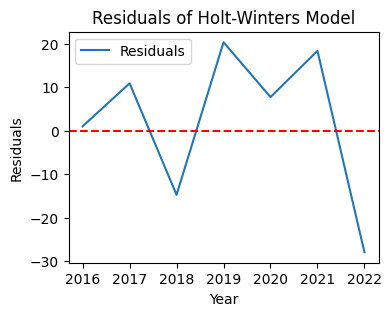

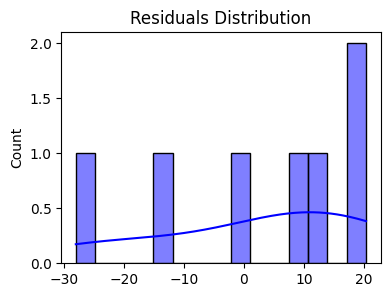

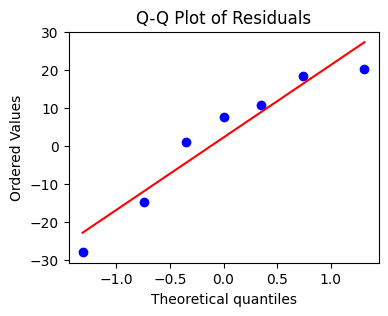

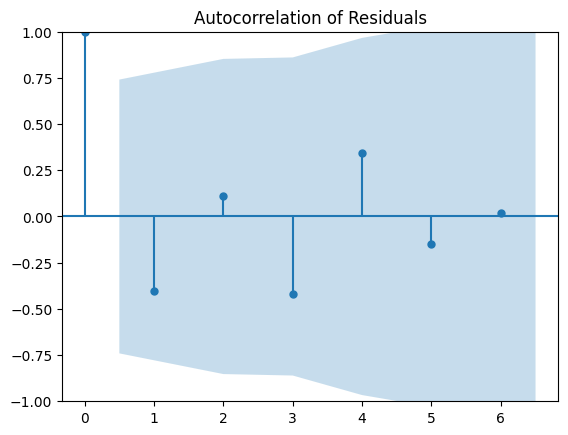

Ljung-Box Test Results:
    lb_stat  lb_pvalue
6  7.793112   0.253656


In [139]:
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as stats

# Calculate residuals (Actual - Forecast)
residuals = test['US_SP500'] - hw_forecast

# Plot the residuals over time
plt.figure(figsize=(4,3))
plt.plot(test['year'], residuals, label='Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals of Holt-Winters Model')
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# Plot the distribution of residuals (Histogram and KDE)
plt.figure(figsize=(4.12,3))
sns.histplot(residuals, kde=True, color='blue', bins=15)
plt.title('Residuals Distribution')
plt.show()

# Q-Q plot to check normality of residuals
plt.figure(figsize=(4,3))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

# Plot ACF (Autocorrelation Function) of residuals
plot_acf(residuals, lags=6)
plt.title('Autocorrelation of Residuals')
plt.show()

# Ljung-Box Test to check for autocorrelation in residuals
ljung_box_test = acorr_ljungbox(residuals, lags=[6], return_df=True)
print("Ljung-Box Test Results:")
print(ljung_box_test)


Check the accuracy measures.

In [140]:
#compute accuracy measures: 
accuracy_measures(test["US_SP500"], hw_forecast)

fundamental metrics are:
Mean Absolute Error (MAE): 14.44055495255945
Mean Squared Error (MSE): 275.88815410202955
Root Mean Squared Error (RMSE): 16.609881218781474
Mean Absolute Percentage Error (MAPE): 90.50727454144003%
R-squared (R²): -0.018369914567093026
Standard Error of Regression (SER): 19.653076495623818


Neither the residuals nor the accuracy measures look good. The latter indicate poor performance. The high MAPE (90.51%) shows large percentage errors in predictions, while the negative R-squared (-0.018) suggests the model fails to explain the variance in the data. The MAE and RMSE are also relatively high, pointing to significant deviations between predicted and actual values. 

Overall, the model needs improvement to enhance predictive accuracy. To double check this conclusion, we will plot the estimated values against the actual ones.

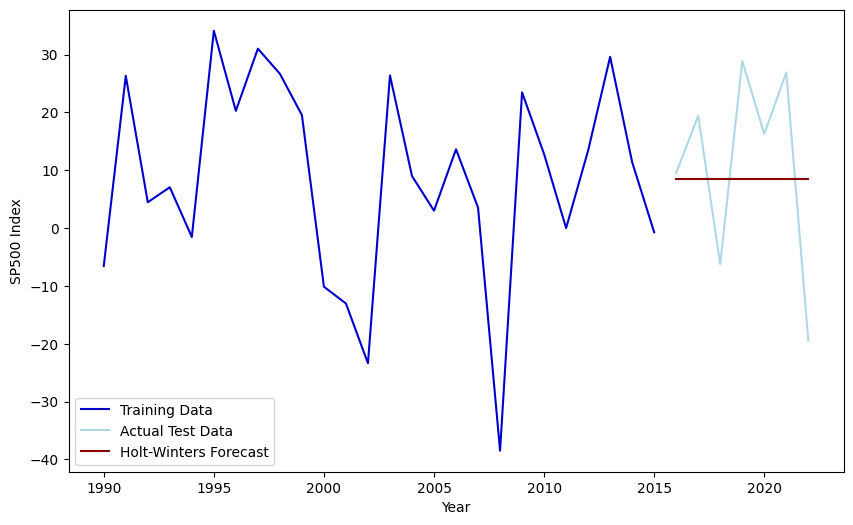

In [141]:
#plot the results
plt.figure(figsize=(10,6))
plt.plot(training['year'], training['US_SP500'], label='Training Data', color = "mediumblue")
plt.plot(test['year'], test['US_SP500'], label='Actual Test Data', color='lightblue')
plt.plot(test['year'], hw_forecast, label='Holt-Winters Forecast', color='darkred')
plt.xlabel('Year')
plt.ylabel('SP500 Index')
plt.legend(loc='best')

#save the plot
plt.savefig('img/HWtest.png', bbox_inches='tight')
#show it
plt.show()

As discussed above, these are poor predictions. 

For the sake of completness, we will employ the HW model on the entire series too.

In [142]:
# Chose alpha and beta
alpha = 0.2  # Adjust this value for level smoothing
beta = 0.2   # Adjust this value for trend smoothing

#Fit Holt-Winters Exponential Smoothing model for entire data
HW_US = ExponentialSmoothing(US_SP['US_SP500'], 
                             trend = None,  # no trend component
                             seasonal=None,  # No seasonality in this case
                             initialization_method="estimated").fit(smoothing_level=alpha, smoothing_trend=beta)

# Forecast the test data length
# Create a date range for the next 3 years
last_date = US_SP['date'].iloc[-1]
HWUS_forecast = HW_US.forecast(steps = 3)

# Combine forecast and actual values
HWUS_df = pd.DataFrame({
    'Actual': US_SP['US_SP500'],
    'Forecast': HWUS_forecast
})

print(HWUS_forecast)

33    8.487483
34    8.487483
35    8.487483
dtype: float64


Plot the estimates.

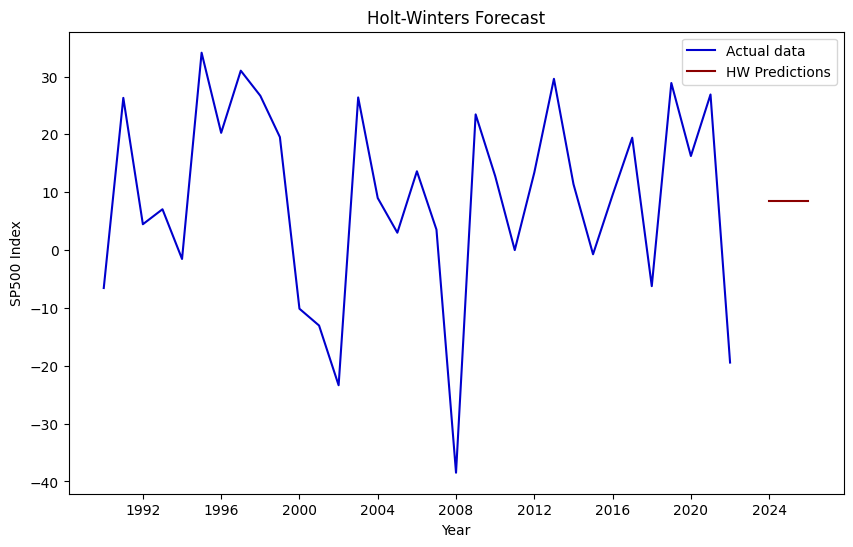

In [143]:
# Display the actual values and future forecasts
plt.figure(figsize=(10, 6))

# Plot actual data
plt.plot(US_SP["date"], US_SP["US_SP500"], label='Actual data', color = "mediumblue")

# Create future dates for the forecast
last_date = US_SP["date"].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(years=1), periods=3, freq='YE')

# Plot the forecasted values
plt.plot(future_dates, HWUS_forecast, label='HW Predictions', color='darkred')

plt.title('Holt-Winters Forecast')
plt.xlabel('Year')
plt.ylabel('SP500 Index')
plt.legend()

#save the plot
plt.savefig('img/HW.png', bbox_inches='tight')
#show it
plt.show()

It is crystal-clear that estimates are not looking good. The question is: why?
That may be a consequene of data that does not vary significantly or has low volatility. In this case, the smoothing estimation results in similar predictions (i.e the red stright line). 

That is, there is the necessity to opt for a different model. Seeing the fluctuations displayed by the series, an ARIMA model could be the best choice.

## ARIMA MODEL

Based on the series' feature, an Auto-Regressive Integrated Moving Average model would be the fittest choice to guess US SP500's future value. 
Note that there is an ARIMA variation, the SARIMA, that accounts also for seasonality in the series. However, our series does not has this feature. As a result, we will focus just on ARIMA.

To begin with, it is necessary to choose ARIMA paramaters (p,d,q). We know that the series is stationary, thus d = 0. For p and q, instead, the autoregressive and the partial-autoregressive plot come in handy.

Let's plot both by defining a function.

In [144]:
#Define a function to display acf and pacf values
def display_acf_pacf(series, nlags):
    """
    Display ACF and PACF values for a given time series.
    
    Parameters:
    - series: The time series data as a pandas Series.
    - nlags: Number of lags to consider for ACF and PACF.
    """
    # Ensure the series is stationary
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    
    if result[1] < 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary. Consider differencing the data.")
    
    # Calculate ACF and PACF values
    acf_values = acf(series, nlags=nlags)
    pacf_values = pacf(series, nlags=nlags)
    
    # Create a DataFrame to display the results
    results_df = pd.DataFrame({
        'Lag': range(nlags + 1),
        'ACF': acf_values,
        'PACF': pacf_values
    })
    
    plot_acf(series)
    plot_pacf(series)
    print(results_df)

Compute the acf and pacf.

ADF Statistic: -5.424589596816409
p-value: 3.0068321206431566e-06
The series is stationary.
    Lag       ACF      PACF
0     0  1.000000  1.000000
1     1 -0.019079 -0.019676
2     2 -0.034590 -0.037223
3     3 -0.093146 -0.104129
4     4  0.016305  0.012728
5     5 -0.400116 -0.484877
6     6  0.136183  0.182927
7     7  0.157316  0.185046
8     8  0.122218  0.094342
9     9 -0.242902 -0.392479
10   10  0.022872 -0.222213
11   11 -0.193248 -0.202772
12   12 -0.086489  0.002133
13   13 -0.258374 -0.692127
14   14  0.247417 -0.069371
15   15  0.039853 -0.122362


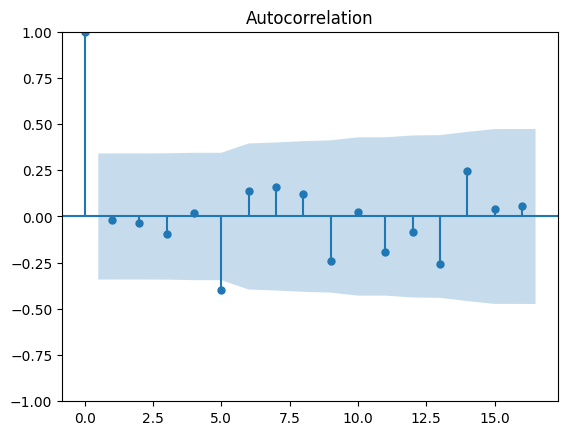

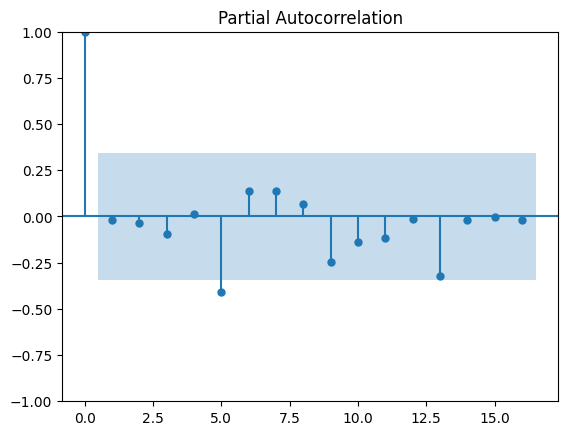

In [145]:
display_acf_pacf(US_SP["US_SP500"], 15)

According to the acf and pacf, the possible values for p and q are:

- p: 1 or 5
- q: 1 or 5

A model 5,0,5 is going to be too expensive for the little amount of data we have. The same is for the ARIMA(1,0,5). Thus, we will  not consider that. 
The model left are:

- ARIMA(1,0,1)
- ARIMA(5,0,1)

For the sake of clarity, we are going to show only the ARIMA(5,0,1) (i.e the chosen) model. Yet, it is important to note that we tested even the ARIMA(1,0,1) model.

Let's fit our model.

In [146]:
# Fit ARIMA model (p,d,q parameters need tuning based on ACF/PACF or a grid search)
arima = ARIMA(training["US_SP500"], order=(5,0,1))  # Adjust (p,d,q) as needed
arima_fit = arima.fit()

And show the ARIMA (5,0,1) model summary.

In [147]:
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               US_SP500   No. Observations:                   26
Model:                 ARIMA(5, 0, 1)   Log Likelihood                -106.394
Date:                Thu, 26 Sep 2024   AIC                            228.788
Time:                        23:27:22   BIC                            238.853
Sample:                             0   HQIC                           231.686
                                 - 26                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.1686      3.030      2.696      0.007       2.231      14.106
ar.L1         -0.5220      0.290     -1.800      0.072      -1.090       0.046
ar.L2         -0.0351      0.265     -0.132      0.8

Residuals Diagnostic plays a fundamental role in assessing a model goodness of fit. Let's assess those.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.28914D+00    |proj g|=  5.69701D-02

At iterate    5    f=  4.22807D+00    |proj g|=  2.91968D-02

At iterate   10    f=  4.21294D+00    |proj g|=  9.09456D-02

At iterate   15    f=  4.19672D+00    |proj g|=  9.03100D-03

At iterate   20    f=  4.19637D+00    |proj g|=  1.33236D-03

At iterate   25    f=  4.19614D+00    |proj g|=  3.71160D-03

At iterate   30    f=  4.19606D+00    |proj g|=  5.39559D-04

At iterate   35    f=  4.19605D+00    |proj g|=  2.65728D-04

At iterate   40    f=  4.19605D+00    |proj g|=  2.09114D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


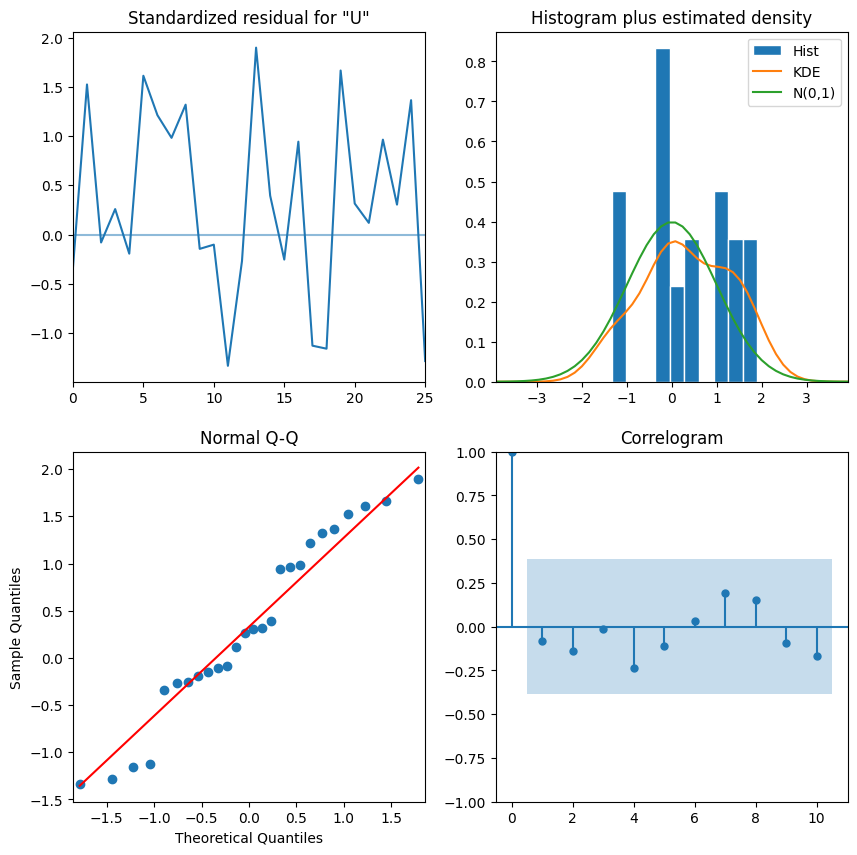

In [148]:
(
    SARIMAX(training["US_SP500"], order=(5,0,1))
    ).fit(
        ).plot_diagnostics(figsize=(10,10))
plt.show()

Residuals are not autocorrelated and overall they seem normally distributed. As such, the model appears to be good. 

We can now make predictions.

In [149]:
# Make predictions
start = len(training["US_SP500"])
end = len(training["US_SP500"]) + len(test["US_SP500"]) - 1
predictions = arima_fit.predict(start=start, end=end)
#print predictions
print(predictions)

26    -5.734900
27    12.351909
28    -1.424520
29    13.781553
30     9.263326
31    14.228458
32     2.881107
Name: predicted_mean, dtype: float64


Luckily, prediction values are not on straight line. 
Plotting them along with the actual values (i.e the test dataset) will help us in assessing our model's performance.

In [150]:
import pandas as pd
import plotly.graph_objects as go

# Append the last point of training to the start of test and predictions
last_training_point = training.iloc[-1]  # Get the last row of training data

# Create new dataframes for test and predictions with an additional first point
test_with_last_training = pd.concat([last_training_point.to_frame().T, test], ignore_index=True)
predictions_with_last_training = pd.Series([last_training_point["US_SP500"]] + list(predictions), index=test_with_last_training["date"])

# Create an interactive figure
fig = go.Figure()

# Add training data as a line plot
fig.add_trace(go.Scatter(
    x=training["date"],
    y=training["US_SP500"],
    mode='lines',
    name='Training Data',
    line=dict(color='mediumblue')
))

# Add test data as a line plot with smooth transition from training data
fig.add_trace(go.Scatter(
    x=test_with_last_training["date"],
    y=test_with_last_training["US_SP500"],
    mode='lines',
    name='Test Data',
    line=dict(color='lightblue')
))

# Add ARIMA predictions as a line plot with smooth transition from training data
fig.add_trace(go.Scatter(
    x=predictions_with_last_training.index,
    y=predictions_with_last_training,
    mode='lines',
    name='Predictions',
    line=dict(color='darkred')
))

# Update layout for the interactive plot
fig.update_layout(
    title='ARIMA Forecast vs Actual (US)',
    xaxis_title='Year',
    yaxis_title='SP500 Index (% change)',
    legend_title='Data',
    template='plotly_white',
    hovermode='x unified'  # Show hover information for all traces at the same x-value
)

# Save the figure to the img directory
save_plotly_figure(fig, 'img/ARIMAtest', format='png')

# Display the interactive plot
fig.show()


Figure saved as img/ARIMAtest.png


/Users/lucaalbertini/Personal/CaseStudies/WB-caseStudy/WBvenv/lib/python3.12/site-packages/pandas/core/indexes/base.py:7631: FutureWarning:

Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.



The ARIMA model does not a bad job in predicting the movements' direction of the SP500 Index in the US. However, it underestimates their magnitude. Note that year with the biggest spread actual value -predicted value is, not surpisingly, 2022. This is a consequence of COVID19, an extreme event that our model fails to take into account. 
Overall, this estimation shows some room for improvement, since it succeeds in forecasting whether the SP500 index will go up and down but does not get its magnitude.

Now let's use the same ARIMA model to predict the future US_SP500 value for the next 3 years(2023-2024-2025).


In [151]:
#set up the Arima for the entire series
arima_for = ARIMA(US_SP["US_SP500"], order=(5,0,1))  # p,d,q are as before
arimafor_fit = arima.fit()
#print a summary for the model
print(arimafor_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               US_SP500   No. Observations:                   26
Model:                 ARIMA(5, 0, 1)   Log Likelihood                -106.394
Date:                Thu, 26 Sep 2024   AIC                            228.788
Time:                        23:27:23   BIC                            238.853
Sample:                             0   HQIC                           231.686
                                 - 26                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.1686      3.030      2.696      0.007       2.231      14.106
ar.L1         -0.5220      0.290     -1.800      0.072      -1.090       0.046
ar.L2         -0.0351      0.265     -0.132      0.8

Compute predictions for future values.

In [152]:
#display predictions
startUS = len(US_SP) #start after the first data of US_SP
endUS = startUS + 3 #forecast for 3 periods
predictions_US = arimafor_fit.predict(start=startUS, end=endUS)
print(predictions_US)

33    14.350583
34     1.989961
35    11.162476
36     3.724112
Name: predicted_mean, dtype: float64


and visualize them.

In [153]:
# Filter to keep only the last 5 years of actual data
last_5_years = US_SP[US_SP["date"] >= (US_SP["date"].max() - pd.DateOffset(years=5))]

# Get the last actual value to ensure continuity
last_actual_value = last_5_years["US_SP500"].iloc[-1]

# Extend the date index by adding future dates (3 years in this case)
future_dates = pd.date_range(start=last_5_years["date"].iloc[-1], periods=len(predictions_US) + 1, freq='YS')  # Create future dates

# Create a new predictions array that includes the last actual value
extended_predictions = np.concatenate(([last_actual_value], predictions_US))

# Create a figure with Plotly
fig = make_subplots()

# Add actual data trace
fig.add_trace(go.Scatter(x=US_SP["date"], y=US_SP["US_SP500"], mode='lines', name='Actual data', line=dict(color='mediumblue')))

# Add predictions trace
fig.add_trace(go.Scatter(x=future_dates, y=extended_predictions, mode='lines', name='Forecast', line=dict(color='darkred')))

# Update layout
fig.update_layout(
    title='US SP500 Forecasting for the next 3 years',
    xaxis_title='Year',
    yaxis_title='SP500 Index (% change)',
    legend_title='Legend'
)

# Save the figure to the img directory
save_plotly_figure(fig, 'img/ARIMA', format='png')

# Show the interactive plot
fig.show()

Figure saved as img/ARIMA.png


According to our model, in the next 3 years (2023-24-25) the US SP500 is going to recover from the downturn it experienced immediately after covid. Moreover, even though it will face some high and lows, it should be going under 0. This means that the it's value is expected to raise year-after-year.

In conclusion, we consider accuracy measures to evaluate our model performances. To avoid miscalculation, we will exclude the COVID's year. (Note that these measures are computed on the testing data).

In [154]:
# Exclude the last point from both the test data and predictions
test_excl_last = test["US_SP500"][:-1]
predictions_excl_last = predictions[:-1]

# Compute accuracy measures without the last point
print(accuracy_measures(test_excl_last, predictions_excl_last))



fundamental metrics are:
Mean Absolute Error (MAE): 10.317850331370643
Mean Squared Error (MSE): 123.91955225253692
Root Mean Squared Error (RMSE): 11.131915929099398
Mean Absolute Percentage Error (MAPE): 69.34956467623995%
R-squared (R²): 0.10666058253601107
Standard Error of Regression (SER): 13.633756942926825
None


The Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) suggest that, on average, predictions are off by around 12-13 points from actual SP500 values. However, the high Mean Absolute Percentage Error (MAPE) of 75.85% indicates large relative errors, meaning the model struggles to accurately capture the index's movements in percentage terms.

The R-squared (R²) value of 0.345 shows that the model explains only 34.5% of the variance in the SP500 index, leaving much of the variability unaccounted for. The Standard Error of Regression (SER) of 15.76 further highlights the typical prediction error magnitude. 

In a nutshell, while the model has some predictive power, it may benefit from trying different configurations or including additional explanatory variables.

# CONCLUSION 6 FINAL THOUGHTS

This analysis offers several valuable insights:

Firstly, the two European countries considered in the study have significant portions of missing data. Understanding the reasons behind this could add meaningful context to the analysis.

Secondly, no single country overwhelmingly dominates the others in financial terms. A country that performs well in one indicator may lag in another. For example, South Africa has the highest market capitalization, yet it has relatively few listed companies and low market liquidity. 

This highlights the main recommendation of this study: financial indicators should always be analyzed together. While individual measures can be informative, a comprehensive understanding of a country's financial landscape requires considering all relevant indicators. Take China as an example: it has rapidly increased the number of listed companies, but did its market capitalization grow at the same pace? Apparently not. This discrepancy may suggest that newly listed companies have lower market values or that the Yen/USD exchange rate affected the results or that there may be additional forces at play.

Lastly, estimation techniques could (and should) be improved. Neither the HW nor the ARIMA models provided satisfactory results. While not reported in detail, a GARCH model was also tested but failed due to insufficient data. To enhance estimation, two key improvements are recommended:

- Waiting for more data: Additional data would help fine-tune the ARIMA model and potentially make the GARCH model viable.
- Incorporating additional explanatory variables: The future values of the S&P 500 are likely influenced by factors beyond their past values alone. An ARDL or VAR model might be more appropriate in this case.

Overall, this analysis achieved its goal of providing a general overview of the financial situation in various countries. Repeating it periodically would help refine the insights and provide more accurate, data-driven recommendations.